In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from cryptography.fernet import Fernet
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import os


Bilgi: skimage.metrics kütüphanesinden PSNR ve SSIM fonksiyonları başarıyla yüklendi.
🔑 Kullanılan Şifreleme Anahtarı: 170
🔑 Şifreleme/Deşifreleme için Anahtar Biti (Anahtar LSB'si): 0
ℹ️ Gizli görselin MSB düzlemi şifrelendi.
ℹ️ Şifrelenmiş MSB düzlemi kapak görselinin Blue kanalının LSB'lerine gizlendi.
ℹ️ Gizlenmiş bitler (şifreli MSB düzlemi) stego görselinden çıkarıldı.
ℹ️ Çıkarılan MSB düzlemi deşifre edildi.

🔍 Görsellik Performansı (Kapak vs Stego):
PSNR: 55.93 dB
SSIM: 1.0000

📤 Gizli Görsel Kurtarma Performansı (Orijinal Gizli vs Çıkarılan & Deşifre Edilmiş MSB):
PSNR: 11.41 dB
SSIM: 0.3781


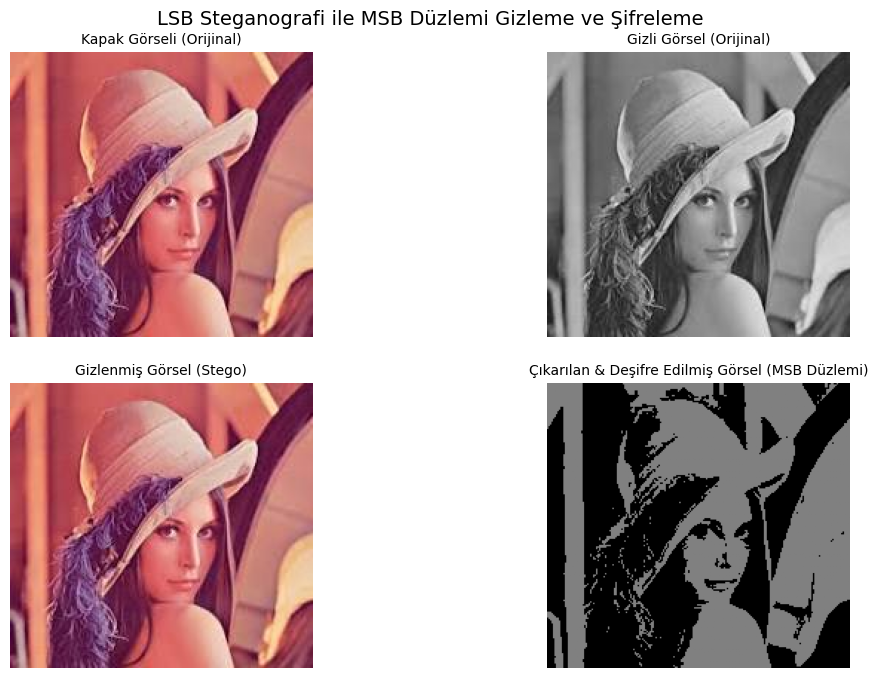

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ÖNEMLİ NOT: psnr ve ssim fonksiyonları için skimage.metrics kullanmanız önerilir.
# Aşağıdakiler sadece temel placeholder fonksiyonlardır ve gerçek metrikler kadar doğru sonuç vermeyebilir.
# Eğer skimage kurulu değilse: pip install scikit-image
try:
    from skimage.metrics import peak_signal_noise_ratio as psnr
    from skimage.metrics import structural_similarity as ssim
    print("Bilgi: skimage.metrics kütüphanesinden PSNR ve SSIM fonksiyonları başarıyla yüklendi.")
except ImportError:
    print("Uyarı: skimage.metrics kütüphanesi bulunamadı. Basit placeholder PSNR ve SSIM fonksiyonları kullanılacak.")
    print("Doğru metrikler için 'pip install scikit-image' ile kütüphaneyi kurmanız önerilir.")
    # Basit PSNR placeholder
    def psnr(image_true, image_test, data_range=255.0): # data_range eklendi
        image_true = image_true.astype(np.float64)
        image_test = image_test.astype(np.float64)
        mse = np.mean((image_true - image_test) ** 2)
        if mse == 0:
            return float('inf')
        # max_pixel = data_range # data_range kullanılıyor
        return 20 * np.log10(data_range / np.sqrt(mse))

    # Basit SSIM placeholder (Bu gerçek SSIM değildir, sadece bir benzerlik ölçütü sunar)
    def ssim(img1, img2, data_range=255.0):
        img1 = img1.astype(np.float64)
        img2 = img2.astype(np.float64)
        # Bu placeholder, gerçek SSIM'in karmaşıklığını yansıtmaz.
        mu1, mu2 = np.mean(img1), np.mean(img2)
        var1, var2 = np.var(img1), np.var(img2)
        covar = np.mean((img1 - mu1) * (img2 - mu2))
        c1 = (0.01 * data_range)**2
        c2 = (0.03 * data_range)**2
        numerator = (2 * mu1 * mu2 + c1) * (2 * covar + c2)
        denominator = (mu1**2 + mu2**2 + c1) * (var1 + var2 + c2)
        if denominator == 0:
            return 1.0 if numerator == 0 else 0.0 # Duruma göre bir değer döndür
        return numerator / denominator


# ----- KOD BAŞLANGICI -----
# Görselleri oku
cover_img_bgr = cv2.imread('lena_rgb.jpeg')  # Renkli görüntü (OpenCV BGR olarak okur)
secret_img_gray = cv2.imread('lena_grey.jpeg', cv2.IMREAD_GRAYSCALE)  # Gri tonlamalı görüntü

# Görsellerin başarıyla yüklenip yüklenmediğini kontrol et
if cover_img_bgr is None:
    print("Hata: Kapak görseli ('lena_rgb.jpeg') yüklenemedi. Dosya yolu doğru mu?")
    exit()
if secret_img_gray is None:
    print("Hata: Gizli görsel ('lena_grey.jpeg') yüklenemedi. Dosya yolu doğru mu?")
    exit()

# Matplotlib RGB olarak beklediği için BGR'dan RGB'ye dönüştür (gösterim için)
cover_img_rgb = cv2.cvtColor(cover_img_bgr, cv2.COLOR_BGR2RGB)

# Boyut eşitle
secret_img_resized = cv2.resize(secret_img_gray, (cover_img_bgr.shape[1], cover_img_bgr.shape[0]))

# ----- ŞİFRELEME ANAHTARI VE GİZLİ GÖRSELİN MSB'SİNİN ŞİFRELENMESİ -----
encryption_key = 170
print(f"🔑 Kullanılan Şifreleme Anahtarı: {encryption_key}")

secret_msb_plane = (secret_img_resized >> 7)
key_bit_for_encryption = encryption_key & 1
print(f"🔑 Şifreleme/Deşifreleme için Anahtar Biti (Anahtar LSB'si): {key_bit_for_encryption}")

encrypted_msb_plane = secret_msb_plane ^ key_bit_for_encryption
print("ℹ️ Gizli görselin MSB düzlemi şifrelendi.")
# ----- ŞİFRELEME KISMI SONU -----

# LSB ile gizleme
stego_img_bgr = cover_img_bgr.copy()
stego_img_bgr[:, :, 0] = (cover_img_bgr[:, :, 0] & 0xFE) | encrypted_msb_plane
print("ℹ️ Şifrelenmiş MSB düzlemi kapak görselinin Blue kanalının LSB'lerine gizlendi.")

# Gizli görseli çıkar
extracted_encrypted_msb_plane = (stego_img_bgr[:, :, 0] & 0x01)
print("ℹ️ Gizlenmiş bitler (şifreli MSB düzlemi) stego görselinden çıkarıldı.")

# ----- ÇIKARILAN BİTLERİN DEŞİFRELENMESİ -----
decrypted_msb_plane = extracted_encrypted_msb_plane ^ key_bit_for_encryption
print("ℹ️ Çıkarılan MSB düzlemi deşifre edildi.")
# ----- DEŞİFRELEME KISMI SONU -----

extracted_img_reconstructed = (decrypted_msb_plane << 7).astype(np.uint8)

# ----- Performans ölçümleri -----
# DÜZELTME: psnr çağrılarına data_range=255.0 eklendi
psnr_value = psnr(cover_img_bgr.astype(np.float64), stego_img_bgr.astype(np.float64), data_range=255.0)
ssim_value = ssim(cv2.cvtColor(cover_img_bgr, cv2.COLOR_BGR2GRAY),
                  cv2.cvtColor(stego_img_bgr, cv2.COLOR_BGR2GRAY),
                  data_range=255.0)

# DÜZELTME: psnr çağrılarına data_range=255.0 eklendi
recovery_psnr = psnr(secret_img_resized.astype(np.float64), extracted_img_reconstructed.astype(np.float64), data_range=255.0)
recovery_ssim = ssim(secret_img_resized, extracted_img_reconstructed, data_range=255.0)

# Sonuçları yazdır
print("\n🔍 Görsellik Performansı (Kapak vs Stego):")
print(f"PSNR: {psnr_value:.2f} dB")
print(f"SSIM: {ssim_value:.4f}")

print("\n📤 Gizli Görsel Kurtarma Performansı (Orijinal Gizli vs Çıkarılan & Deşifre Edilmiş MSB):")
print(f"PSNR: {recovery_psnr:.2f} dB")
print(f"SSIM: {recovery_ssim:.4f}")

# Görselleri göster
titles = ['Kapak Görseli (Orijinal)', 'Gizli Görsel (Orijinal)',
          'Gizlenmiş Görsel (Stego)', 'Çıkarılan & Deşifre Edilmiş Görsel (MSB Düzlemi)']

stego_img_rgb_display = cv2.cvtColor(stego_img_bgr, cv2.COLOR_BGR2RGB)
images_to_show = [cover_img_rgb, secret_img_resized,
                  stego_img_rgb_display, extracted_img_reconstructed]

plt.figure(figsize=(13, 7))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    if titles[i] == 'Gizli Görsel (Orijinal)' or titles[i] == 'Çıkarılan & Deşifre Edilmiş Görsel (MSB Düzlemi)':
        plt.imshow(images_to_show[i], cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(images_to_show[i])
    plt.title(titles[i], fontsize=10)
    plt.axis('off')
plt.tight_layout(pad=2.0)
plt.suptitle("LSB Steganografi ile MSB Düzlemi Gizleme ve Şifreleme", fontsize=14)
plt.subplots_adjust(top=0.92)
plt.show()

## lsb olmaya .alısıyort 


✅ PSNR ve SSIM fonksiyonları başarıyla yüklendi.


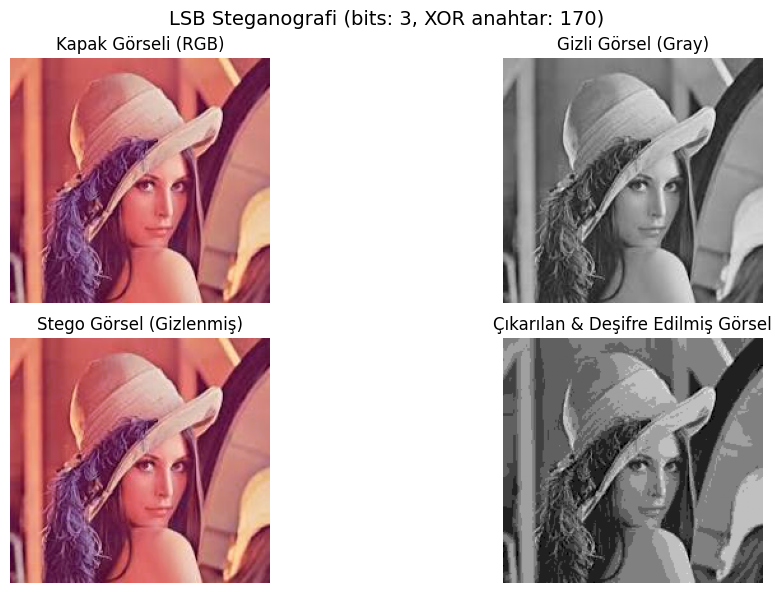


📊 Görsellik (Kapak vs Stego):
PSNR: 42.22 dB
SSIM: 0.9990

📤 Gizli Görsel Kurtarma (Orijinal vs Çıkarılan):
PSNR: 23.02 dB
SSIM: 0.8254


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Gerekli metrikler
try:
    from skimage.metrics import peak_signal_noise_ratio as psnr
    from skimage.metrics import structural_similarity as ssim
    print("✅ PSNR ve SSIM fonksiyonları başarıyla yüklendi.")
except ImportError:
    print("❌ skimage.metrics bulunamadı. Lütfen `pip install scikit-image` komutunu çalıştırın.")
    exit()

# ----- 1. GÖRSELLERİ YÜKLE -----
cover_img_bgr = cv2.imread('lena_rgb.jpeg')  # BGR formatında
secret_img_gray = cv2.imread('lena_grey.jpeg', cv2.IMREAD_GRAYSCALE)  # Grayscale

if cover_img_bgr is None or secret_img_gray is None:
    print("❌ Görseller yüklenemedi. Dosya adlarını ve yolları kontrol edin.")
    exit()

# Boyutları eşitle
secret_img_resized = cv2.resize(secret_img_gray, (cover_img_bgr.shape[1], cover_img_bgr.shape[0]))

# ----- 2. PARAMETRELER -----
bits_to_hide = 3  # 2, 3 veya 4 olabilir
encryption_key = 170  # XOR anahtarı 
key_bits = encryption_key & ((1 << bits_to_hide) - 1)

# ----- 3. GİZLİ GÖRSELİ ENCODE ET -----
# MSB düzlemlerini al (örneğin en anlamlı 3 bit)
secret_bits = secret_img_resized >> (8 - bits_to_hide)

# XOR şifreleme
encrypted_bits = secret_bits ^ key_bits

# Blue kanalın LSB'lerine yerleştir
stego_img_bgr = cover_img_bgr.copy()
mask = 0xFF - ((1 << bits_to_hide) - 1)  # Alt N biti sıfırla
stego_img_bgr[:, :, 0] = (cover_img_bgr[:, :, 0] & mask) | encrypted_bits

# ----- 4. GİZLİ GÖRSELİ EXTRACT ET -----
extracted_bits_encrypted = stego_img_bgr[:, :, 0] & ((1 << bits_to_hide) - 1)

# XOR ile deşifre
decrypted_bits = extracted_bits_encrypted ^ key_bits

# 8 bit aralığına geri ölçekle
extracted_img_reconstructed = (decrypted_bits << (8 - bits_to_hide)).astype(np.uint8)

# ----- 5. PERFORMANS METRİKLERİ -----
psnr_cover_stego = psnr(cover_img_bgr, stego_img_bgr, data_range=255.0)
ssim_cover_stego = ssim(cv2.cvtColor(cover_img_bgr, cv2.COLOR_BGR2GRAY),
                        cv2.cvtColor(stego_img_bgr, cv2.COLOR_BGR2GRAY),
                        data_range=255.0)

psnr_secret_extracted = psnr(secret_img_resized, extracted_img_reconstructed, data_range=255.0)
ssim_secret_extracted = ssim(secret_img_resized, extracted_img_reconstructed, data_range=255.0)

# ----- 6. SONUÇLARI GÖSTER -----
titles = ['Kapak Görseli (RGB)', 'Gizli Görsel (Gray)',
          'Stego Görsel (Gizlenmiş)', 'Çıkarılan & Deşifre Edilmiş Görsel']

images = [cv2.cvtColor(cover_img_bgr, cv2.COLOR_BGR2RGB), secret_img_resized,
          cv2.cvtColor(stego_img_bgr, cv2.COLOR_BGR2RGB), extracted_img_reconstructed]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    cmap = 'gray' if i == 1 or i == 3 else None
    plt.imshow(images[i], cmap=cmap, vmin=0, vmax=255)
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.suptitle(f"LSB Steganografi (bits: {bits_to_hide}, XOR anahtar: {encryption_key})", fontsize=14)
plt.subplots_adjust(top=0.90)
plt.show()

# ----- 7. METRİKLERİ YAZDIR -----
print("\n📊 Görsellik (Kapak vs Stego):")
print(f"PSNR: {psnr_cover_stego:.2f} dB")
print(f"SSIM: {ssim_cover_stego:.4f}")

print("\n📤 Gizli Görsel Kurtarma (Orijinal vs Çıkarılan):")
print(f"PSNR: {psnr_secret_extracted:.2f} dB")
print(f"SSIM: {ssim_secret_extracted:.4f}")


## sadece lsb l,i olması mlamzım 